In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from scipy.signal import cwt
from scipy.signal import morlet
import pywt
import torch
import torch.nn as nn
import torchaudio
from scipy import signal
from tqdm import tqdm_notebook
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
!pip install torchviz
from torchviz import make_dot

try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
except:
    print("Mounting Failed.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=7fbe096d7ca61f3cd7c48b8409a4d30fc7f816d81173584e6bfa4d751ca2ffc9
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz
Mounted at /content/gdrive


In [3]:
data = pd.read_csv("/content/gdrive/MyDrive/emotions.csv")
print(data['label'].value_counts())
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
data['label'] = data['label'].replace(label_mapping)

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64


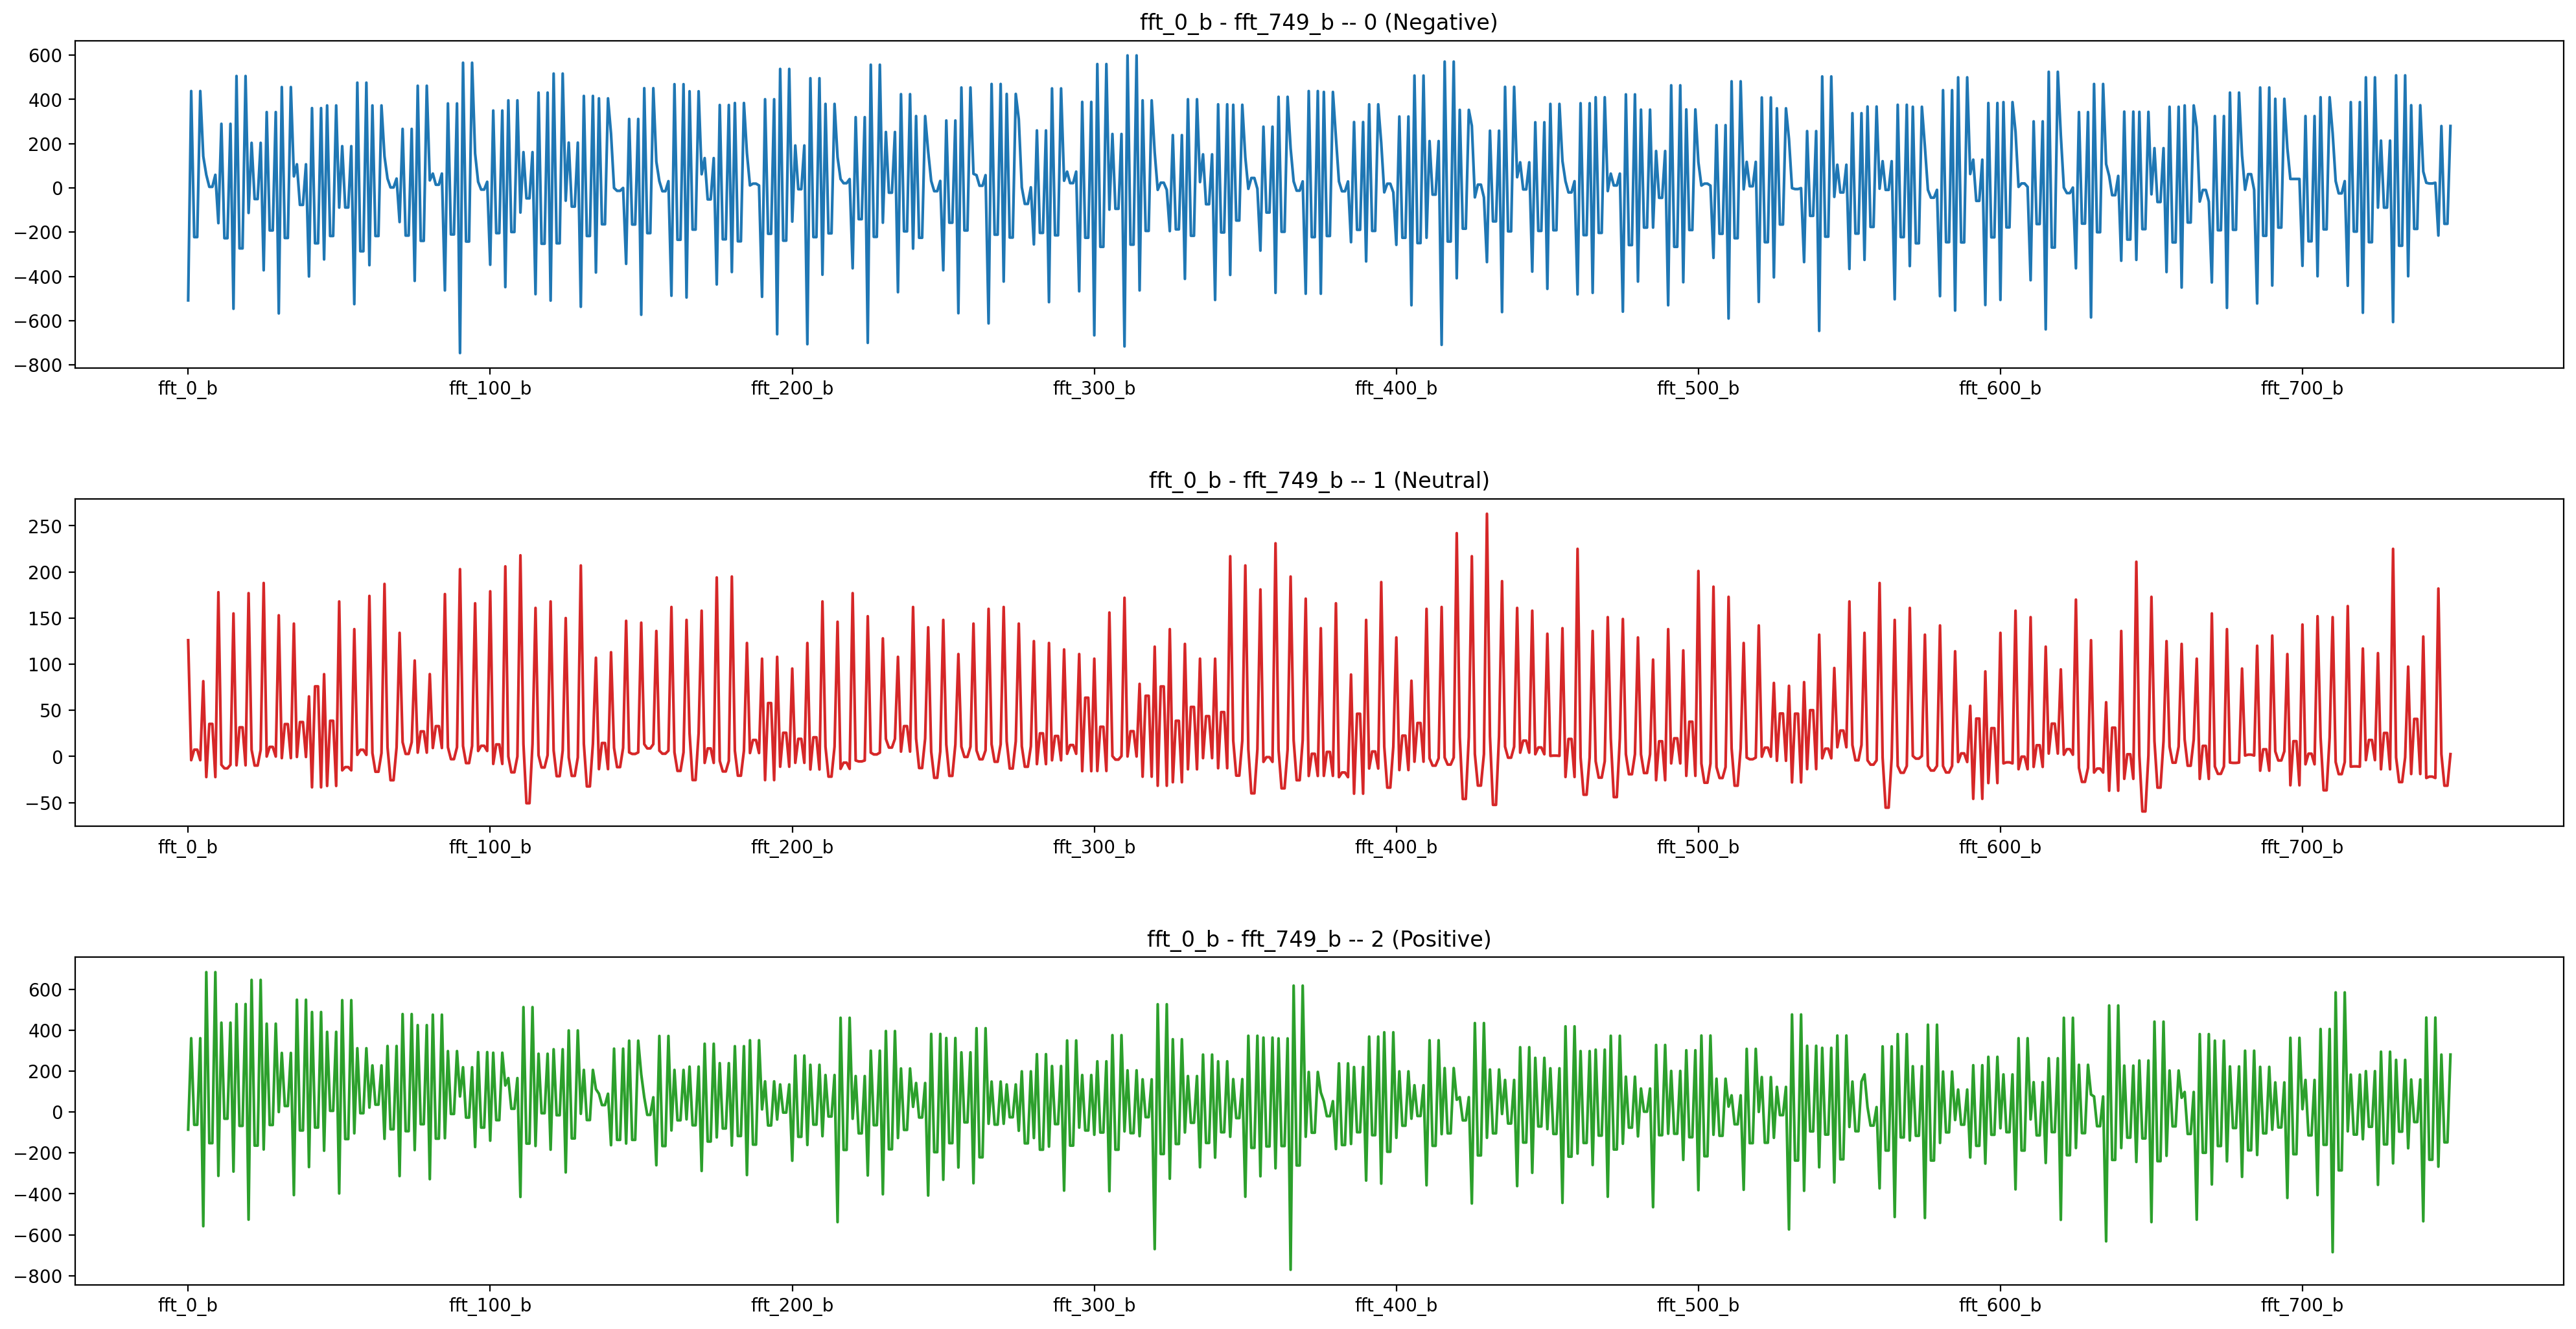

In [ ]:
# visualize EEG samples
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(24, 12))
data.loc[0, 'fft_0_b':'fft_749_b'].plot(title='fft_0_b - fft_749_b -- 0 (Negative)', color='tab:blue', ax=axes[0])
data.loc[1, 'fft_0_b':'fft_749_b'].plot(title='fft_0_b - fft_749_b -- 1 (Neutral)', color='tab:red', ax=axes[1])
data.loc[2, 'fft_0_b':'fft_749_b'].plot(title='fft_0_b - fft_749_b -- 2 (Positive)', color='tab:green', ax=axes[2])

plt.subplots_adjust(left=0.1, bottom=0.1, 
                    right=0.9, top=0.9, 
                    wspace=0.4, hspace=0.4)

In [4]:
class EEGDataset(Dataset):
    def __init__(self, inputs, labels):
        self.x_train = torch.tensor(inputs)
        self.y_train = torch.tensor(labels)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

#preprocessing
inputs = data.drop('label', axis=1)
labels = data['label'].copy()
scaler = StandardScaler()
scaler.fit(inputs)
inputs = scaler.transform(inputs)
#inputs = inputs.to_numpy()
#inputs -= np.mean(inputs, axis=1, keepdims=True)
#inputs /= np.std(inputs, axis=1, keepdims=True)
inputs = normalize(inputs, axis=1, norm='max')
labels_onehot = np.eye(3)[labels]

#datasets
batch_size = 32
dataset = EEGDataset(inputs, labels_onehot)
train_data, test_data = torch.utils.data.random_split(dataset, [1705, 427])

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

gan_data, _ = torch.utils.data.random_split(dataset, [1066, 1066])
gan_dataloader = DataLoader(gan_data, batch_size=batch_size, shuffle=True)

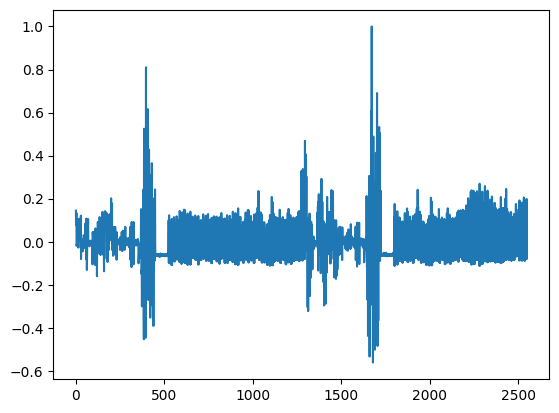

In [7]:
sample = None
negative = np.array([1, 0, 0])
gan_testloader = DataLoader(gan_data, batch_size=1, shuffle=True)
for signal, label in gan_testloader:
    if label[0][0].item() == 0:
        sample = signal
        break

signal = signal.cpu().squeeze(0).numpy()
plt.plot(signal)
plt.show()

In [8]:
torch.set_default_dtype(torch.float64)
class LSTMNet(nn.Module):

    def __init__(self):
        super(LSTMNet, self).__init__()
        self.lstm1 = nn.LSTM(input_size=2548, hidden_size=64, batch_first=True)
        self.dropout1 = nn.Dropout(p=0.2)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc = nn.Linear(32, 3)
        
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        return self.fc(out)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

def eval(model, dataloader):
    model.eval()
    correct = 0
    loss_sum = 0
    total = 0
    for inputs, labels in dataloader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        total += len(labels)
        outputs = model(inputs)
        loss_sum += criterion(outputs, labels).item()
        predictions = torch.max(outputs, dim=1)[1]
        labels = torch.max(labels, dim=1)[1]
        correct += (predictions == labels).sum().item()
    return 100.0 * correct / total, loss_sum / total


In [ ]:
learning_rate = 1e-3

model = LSTMNet()
model.apply(init_weights)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

def train(model,
          optimizer=optimizer,
          scheduler=scheduler,
          criterion=criterion,
          epochs=200,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader,
          patience = 15):
    """
    
    """

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    best_test_loss = math.inf
    stagnant_epochs = 0

    for epoch in range(0, epochs):
        print("\nEPOCH " +str(epoch+1)+" of "+str(epochs)+"\n")
        correct = 0
        total = 0
        loss_sum = 0
        for i, (signals, labels) in enumerate(train_dataloader):
            model.train()
            signals = signals.cuda()
            labels = labels.cuda()
            outputs = model.forward(signals)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss
            total += len(labels)
            predictions = torch.max(outputs, dim=1)[1]
            labels = torch.max(labels, dim=1)[1]
            correct += (predictions == labels).sum().item()

        tr_acc, tr_loss = 100.0 * correct / total, loss_sum.item() / total
        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        print('  Train accuracy: %f %%' % tr_acc)
        print('  Train loss: %f' % tr_loss)

        tst_acc, tst_loss = eval(model, test_dataloader)
        test_losses.append(tst_loss)
        test_accs.append(tst_acc)
        print('  Test accuracy: %f %%' % tst_acc)
        print('  Test loss: %f' % tst_loss)

        if tst_loss < best_test_loss:
            best_test_loss = tst_loss
            stagnant_epochs = 0
        else:
            stagnant_epochs += 1
        if stagnant_epochs == patience:
            print("Early stop triggered.")
            break
        
        scheduler.step()
        print()
    
    return train_losses, train_accs, test_losses, test_accs

In [ ]:
train_losses, train_accs, test_losses, test_accs = train(model)
torch.save(model, "/content/gdrive/MyDrive/eeg_lstm.pt")


EPOCH 1 of 200

  Train accuracy: 72.551320 %
  Train loss: 0.023446
  Test accuracy: 89.227166 %
  Test loss: 0.013103


EPOCH 2 of 200

  Train accuracy: 92.258065 %
  Train loss: 0.008998
  Test accuracy: 90.866511 %
  Test loss: 0.007759


EPOCH 3 of 200

  Train accuracy: 94.252199 %
  Train loss: 0.005932
  Test accuracy: 92.037471 %
  Test loss: 0.006347


EPOCH 4 of 200

  Train accuracy: 95.483871 %
  Train loss: 0.004424
  Test accuracy: 92.740047 %
  Test loss: 0.006096


EPOCH 5 of 200

  Train accuracy: 96.011730 %
  Train loss: 0.003799
  Test accuracy: 93.442623 %
  Test loss: 0.005089


EPOCH 6 of 200

  Train accuracy: 97.360704 %
  Train loss: 0.002878
  Test accuracy: 94.379391 %
  Test loss: 0.004566


EPOCH 7 of 200

  Train accuracy: 98.475073 %
  Train loss: 0.001931
  Test accuracy: 96.487119 %
  Test loss: 0.003058


EPOCH 8 of 200

  Train accuracy: 99.002933 %
  Train loss: 0.001174
  Test accuracy: 96.252927 %
  Test loss: 0.003226


EPOCH 9 of 200

  Train

In [ ]:
torch.save(model, "/content/gdrive/MyDrive/eeg_lstm_v2normed.pt")

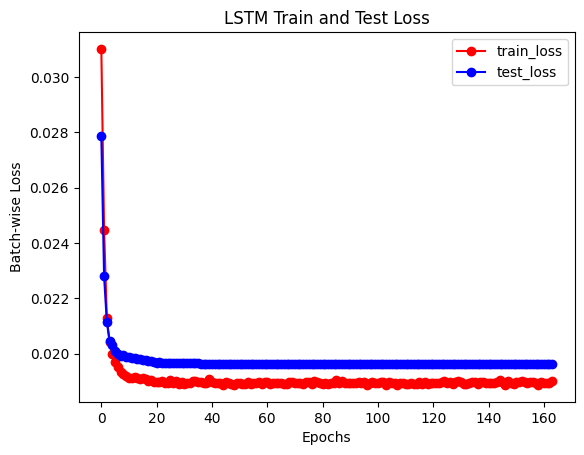

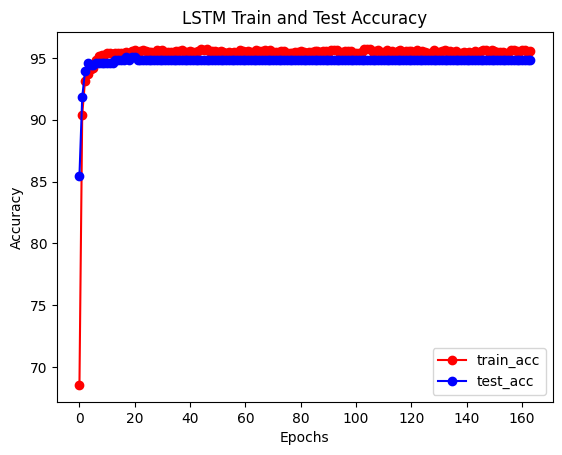

In [ ]:
plt.plot(train_losses, '-o', label = 'train_loss', color = 'red')
plt.plot(test_losses, '-o', label = 'test_loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Batch-wise Loss')
plt.title('LSTM Train and Test Loss')
plt.legend(loc="upper right")
plt.show()

plt.plot(train_accs, '-o', label = 'train_acc', color = 'red')
plt.plot(test_accs, '-o', label = 'test_acc', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Train and Test Accuracy')
plt.legend(loc="lower right")
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_default_dtype(torch.float64)
class Generator(nn.Module):
    def __init__(self, noise_dim, signal_dim, hidden_dim, num_layers, class_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.signal_dim = signal_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.class_dim = class_dim

        self.lstm = nn.LSTM(noise_dim + class_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, signal_dim)

    def forward(self, z, c):
        zc = torch.cat([z, c], dim=1).unsqueeze(1)
        h0 = torch.zeros(self.num_layers, z.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, z.size(0), self.hidden_dim).to(device)
        output, _ = self.lstm(zc, (h0, c0))
        output = self.fc(output.squeeze(1))
        return output

class Discriminator(nn.Module):
    def __init__(self, signal_dim, hidden_dim, num_layers, class_dim):
        super(Discriminator, self).__init__()
        self.signal_dim = signal_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.class_dim = class_dim

        self.lstm = nn.LSTM(signal_dim + class_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, c):
        xc = torch.cat([x, c], dim=1).unsqueeze(1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        output, _ = self.lstm(xc, (h0, c0))
        output = self.fc(output)
        output = torch.sigmoid(output.squeeze(1))
        return output


def train_cgan(generator, discriminator, dataloader, num_epochs, noise_dim, class_dim, d_optim, g_optim):

    criterion = nn.BCELoss()
    g_losses = []
    d_losses = []

    for epoch in range(num_epochs):
        for i, (signals, labels) in enumerate(dataloader):
            real_signals = signals.to(device)
            class_labels = labels.to(device)

            # Train discriminator
            d_optim.zero_grad()
            # Discriminate real signals and calculate loss
            real_validity = discriminator(real_signals, class_labels)
            real_loss = criterion(real_validity, torch.ones(signals.size(0)).unsqueeze(1).to(device))
            # Create noise, fake labels, and fake signals
            noise = torch.randn(signals.size(0), noise_dim).to(device)
            fake_labels = torch.FloatTensor(np.eye(3)[np.random.randint(0, class_dim, signals.size(0))]).to(device)
            fake_signals = generator(noise, fake_labels)
            # Discriminate fake signals and calculate loss
            fake_validity = discriminator(fake_signals, fake_labels)
            fake_loss = criterion(fake_validity, torch.zeros(signals.size(0)).unsqueeze(1).to(device))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optim.step()

            # Train generator
            g_optim.zero_grad()
            # Create noise, fake labels, and fake signals
            noise = torch.randn(signals.size(0), noise_dim).to(device)
            fake_labels = torch.FloatTensor(np.eye(3)[np.random.randint(0, class_dim, signals.size(0))]).to(device)
            fake_signals = generator(noise, fake_labels)
            # Discriminate fake signals and calculate loss
            validity = discriminator(fake_signals, fake_labels)
            g_loss = criterion(validity, torch.ones(signals.size(0)).unsqueeze(1).to(device))
            g_loss.backward()
            g_optim.step()

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

        print('Epoch [{}/{}], g_loss: {}, d_loss: {}'.format(epoch, num_epochs, g_loss, d_loss))
                
    return g_losses, d_losses

In [15]:
noise_dim = 100
signal_dim = 2548
hidden_dim = 64
num_layers = 2
class_dim = 3
num_epochs = 1000

generator = Generator(noise_dim, signal_dim, hidden_dim, num_layers, class_dim).to(device)
discriminator = Discriminator(signal_dim, hidden_dim, 1, class_dim).to(device)

input = None
labels = None
for signals, labels in gan_dataloader:
    input = signals.to(device)
    labels = labels.to(device)

graph = make_dot(discriminator(input, labels), params=dict(discriminator.named_parameters()))
graph.render("disc_graph")

'disc_graph.pdf'

In [ ]:
noise_dim = 100
signal_dim = 2548
hidden_dim = 64
num_layers = 2
class_dim = 3
num_epochs = 1000

generator = Generator(noise_dim, signal_dim, hidden_dim, num_layers, class_dim).to(device)
discriminator = Discriminator(signal_dim, hidden_dim, 1, class_dim).to(device)
g_optim = optim.Adam(generator.parameters(), lr=1e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=1e-4)

g_loss, d_loss = train_cgan(generator, discriminator, gan_dataloader, num_epochs, noise_dim, class_dim, d_optim, g_optim)

Epoch [0/1000], g_loss: 0.8803791075667203, d_loss: 1.1330944551899451
Epoch [1/1000], g_loss: 1.101881964092988, d_loss: 0.9052315774190636
Epoch [2/1000], g_loss: 1.2505628889445006, d_loss: 0.7342273674418704
Epoch [3/1000], g_loss: 1.2090315128493483, d_loss: 0.6776176824515612
Epoch [4/1000], g_loss: 1.08950752911953, d_loss: 0.6675504849660409
Epoch [5/1000], g_loss: 1.0330291113534766, d_loss: 0.7357902687175808
Epoch [6/1000], g_loss: 0.9791422378345089, d_loss: 0.6907291866374938
Epoch [7/1000], g_loss: 0.976890200019589, d_loss: 0.6834634748767476
Epoch [8/1000], g_loss: 0.9155703756536753, d_loss: 0.7659666745154692
Epoch [9/1000], g_loss: 0.8573121975060332, d_loss: 0.7103978322683524
Epoch [10/1000], g_loss: 0.7894825091520774, d_loss: 0.7365639882841036
Epoch [11/1000], g_loss: 0.7785385472998616, d_loss: 0.7910699935387389
Epoch [12/1000], g_loss: 0.8172512576848789, d_loss: 0.7507020903866392
Epoch [13/1000], g_loss: 0.864602472213086, d_loss: 0.7726292494744998
Epoch [

In [ ]:
torch.save(generator, "/content/gdrive/MyDrive/eeg_gen_v2.pt")
torch.save(discriminator, "/content/gdrive/MyDrive/eeg_disc_v2.pt")

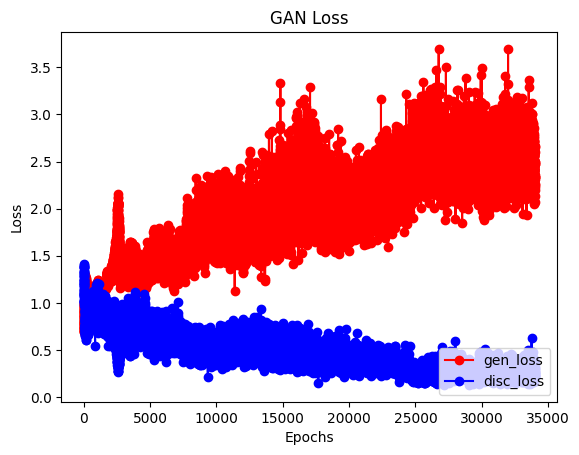

In [ ]:
plt.plot(g_loss, '-o', label = 'gen_loss', color = 'red')
plt.plot(d_loss, '-o', label = 'disc_loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Loss')
plt.legend(loc="lower right")
plt.show()

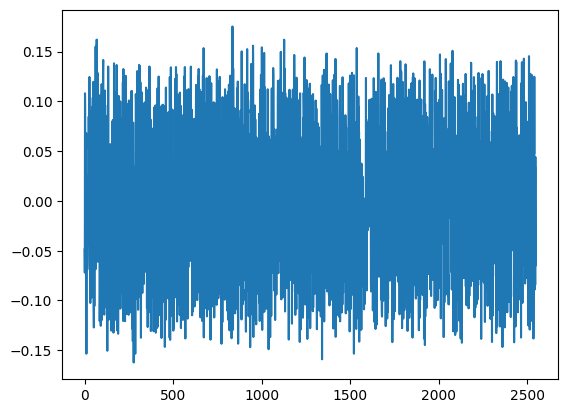

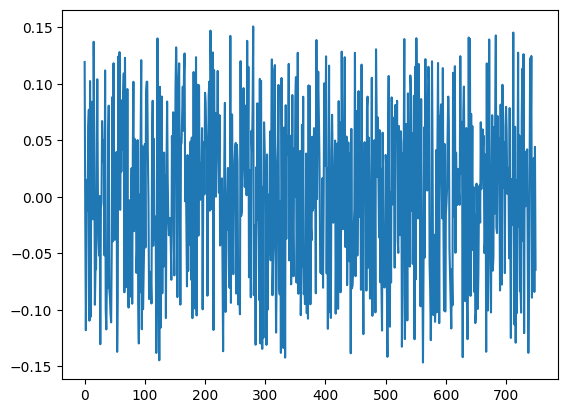

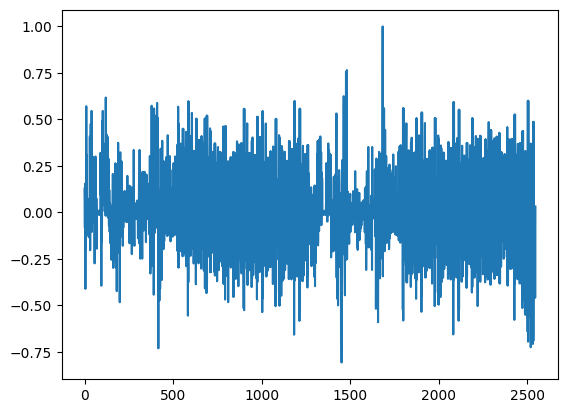

In [16]:
noise = torch.randn(1, noise_dim).to(device)
labels = torch.FloatTensor([1, 0, 0]).unsqueeze(0).to(device)
signal = generator(noise, labels)
eeg = signal.cpu().squeeze(0).detach().numpy()
plt.plot(eeg)
plt.show()
eeg = eeg[-750:]
plt.plot(eeg)
plt.show()

sample = None
negative = np.array([1, 0, 0])
gan_testloader = DataLoader(gan_data, batch_size=1, shuffle=True)
for signal, label in gan_testloader:
    if label[0][0].item() == 1:
        sample = signal
        break

signal = signal.cpu().squeeze(0).numpy()
plt.plot(signal)
plt.show()

In [19]:
generator = torch.load("/content/gdrive/MyDrive/eeg_gen_normed.pt")

noise = torch.randn(1000, 100).to(device)
labels = torch.FloatTensor(np.eye(3)[np.random.randint(0, 3, 1000)]).to(device)
signals = generator(noise, labels)

def synth_eval(model, signals, labels):
    model.eval()
    correct = 0
    loss_sum = 0
    total = len(labels)
    criterion = nn.CrossEntropyLoss()

    outputs = model(signals)
    loss_sum += criterion(outputs, labels).item()
    predictions = torch.max(outputs, dim=1)[1]
    labels = torch.max(labels, dim=1)[1]
    correct += (predictions == labels).sum().item()

    return 100.0 * correct / total, loss_sum / total

model = torch.load("/content/gdrive/MyDrive/eeg_lstm_v2normed.pt")
synth_acc, synth_loss = synth_eval(model, signals, labels)
print("accuracy and loss on synthetic dataset:")
print(synth_acc, synth_loss)

accuracy and loss on synthetic dataset:
89.7 0.00037498494452367767


In [ ]:
'''
Evaluation:
- Run inference of pre-trained model on synthetic data, see if accuracy is consistent
- Train a model on 1/4 of the data, then train on synthetic data and evaluate performance increase
- Create an average EEG signal from 1 class; then generate synthetic data from that class, and create an average synthetic signal
    - compare average signals using correlation metric
'''

'\nEvaluation:\n- Run inference of pre-trained model on synthetic data, see if accuracy is consistent\n- Train a model on 1/4 of the data, then train on synthetic data and evaluate performance increase\n- Create an average EEG signal from 1 class; then generate synthetic data from that class, and create an average synthetic signal\n    - compare average signals using correlation metric\n'

In [ ]:
half_train, half_test = torch.utils.data.random_split(dataset, [300, 1832])
half_train_dataloader = DataLoader(half_train, batch_size=batch_size, shuffle=True)
half_test_dataloader = DataLoader(half_test, batch_size=batch_size, shuffle=False)

learning_rate = 1e-3
model = LSTMNet()
model.apply(init_weights)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

train_losses, train_accs, test_losses, test_accs = train(model,
                                                         optimizer=optimizer,
                                                         scheduler=scheduler,
                                                         criterion=criterion,
                                                         train_dataloader=half_train_dataloader,
                                                         test_dataloader=half_test_dataloader,
                                                         patience=30)



EPOCH 1 of 200

  Train accuracy: 52.000000 %
  Train loss: 0.035743
  Test accuracy: 58.897380 %
  Test loss: 0.032978


EPOCH 2 of 200

  Train accuracy: 59.000000 %
  Train loss: 0.033982
  Test accuracy: 64.574236 %
  Test loss: 0.031375


EPOCH 3 of 200

  Train accuracy: 68.333333 %
  Train loss: 0.032178
  Test accuracy: 69.432314 %
  Test loss: 0.029709


EPOCH 4 of 200

  Train accuracy: 77.666667 %
  Train loss: 0.030224
  Test accuracy: 83.897380 %
  Test loss: 0.028028


EPOCH 5 of 200

  Train accuracy: 83.333333 %
  Train loss: 0.029047
  Test accuracy: 86.408297 %
  Test loss: 0.026298


EPOCH 6 of 200

  Train accuracy: 88.333333 %
  Train loss: 0.027030
  Test accuracy: 90.556769 %
  Test loss: 0.024909


EPOCH 7 of 200

  Train accuracy: 93.000000 %
  Train loss: 0.025443
  Test accuracy: 90.884279 %
  Test loss: 0.023721


EPOCH 8 of 200

  Train accuracy: 94.666667 %
  Train loss: 0.024466
  Test accuracy: 91.375546 %
  Test loss: 0.022925


EPOCH 9 of 200

  Train

In [ ]:
torch.save(model, "/content/gdrive/MyDrive/eeg_lstm_half.pt")

In [ ]:
noise = torch.randn(5000, noise_dim).to(device)
labels = torch.FloatTensor(np.eye(3)[np.random.randint(0, class_dim, 5000)]).to(device)
signals = generator(noise, labels)
synth_dataset = EEGDataset(signals, labels)
synth_loader = DataLoader(synth_dataset, batch_size=batch_size, shuffle=True)


train_losses, train_accs, test_losses, test_accs = train(model,
                                                         optimizer=optimizer,
                                                         scheduler=scheduler,
                                                         criterion=criterion,
                                                         train_dataloader=synth_loader,
                                                         test_dataloader=half_test_dataloader,
                                                         patience=40)

<ipython-input-34-cd9b82e65f58>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_train = torch.tensor(inputs)
<ipython-input-34-cd9b82e65f58>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(labels)



EPOCH 1 of 200

  Train accuracy: 88.980000 %
  Train loss: 0.022231
  Test accuracy: 92.194323 %
  Test loss: 0.021405


EPOCH 2 of 200

  Train accuracy: 88.760000 %
  Train loss: 0.022234
  Test accuracy: 92.194323 %
  Test loss: 0.021405


EPOCH 3 of 200

  Train accuracy: 89.080000 %
  Train loss: 0.022223
  Test accuracy: 92.194323 %
  Test loss: 0.021405


EPOCH 4 of 200

  Train accuracy: 88.940000 %
  Train loss: 0.022233
  Test accuracy: 92.194323 %
  Test loss: 0.021405


EPOCH 5 of 200

  Train accuracy: 88.880000 %
  Train loss: 0.022274
  Test accuracy: 92.194323 %
  Test loss: 0.021405


EPOCH 6 of 200

  Train accuracy: 88.840000 %
  Train loss: 0.022191
  Test accuracy: 92.194323 %
  Test loss: 0.021405


EPOCH 7 of 200

  Train accuracy: 88.980000 %
  Train loss: 0.022217
  Test accuracy: 92.194323 %
  Test loss: 0.021405


EPOCH 8 of 200

  Train accuracy: 89.100000 %
  Train loss: 0.022252
  Test accuracy: 92.194323 %
  Test loss: 0.021405


EPOCH 9 of 200

  Train

In [ ]:
synth_acc, synth_loss = synth_eval(model, signals, labels)
print("accuracy and loss on synthetic dataset:")
print(synth_acc, synth_loss)

accuracy and loss on synthetic dataset:
89.62 0.00013909358216358296
